# ECG Heart Disease Detection Using RandomForest and Multi Layer Perceptron
This work was made based on the Physionet ECG Challenge 2017 dataset https://physionet.org/challenge/2017/

It was the project I started at DataScience Retreat in 2018/Berlin 

The WaveForm DataBase library has helped a lot for extracting the properties from the dataset records https://physionet.org/physiotools/wfdb.shtml

Data Science Retreat

https://github.com/data-science-retreat

https://datascienceretreat.com/

## Importing all the packages

All the packages here make reference to the pipeline for exploring the dataset using Neo4j in order to improve the feature selection.

In [2]:
import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources

from keras.models import Sequential, Model
from keras.layers import LSTM, RepeatVector, Dense
from keras import optimizers

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seglearn as sgl
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import random
from random import randrange
import time
from pandas import Series
from matplotlib import pyplot

import pyprind
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from os import walk
import csv
import shutil
from neo4j import GraphDatabase
import wfdb
from wfdb import processing

## First phase: Extract & Load dataset from wfdb Physionet format and persist into Neo4j

In [5]:
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "neo4jj4neo"))

#https://www.programcreek.com/python/example/92749/neo4j.v1.GraphDatabase.driver

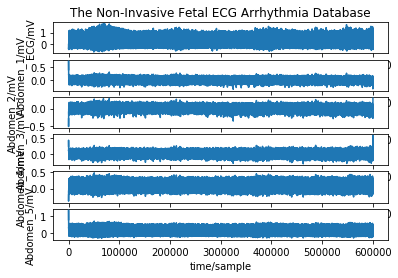

(600052, 6)


In [6]:
#Physionet, The Non-Invasive Fetal ECG Arrhythmia Database
record = wfdb.rdrecord('/media/tiagoooliveira/sda416/databases/physionet/Fetal_ECG_Arrhythmia/training/ARR_01', channels='all')
wfdb.plot_wfdb(record=record, title='The Non-Invasive Fetal ECG Arrhythmia Database') 

print(record.p_signal.shape)
#n-dimension = n-channels => tensor

### Tests on extracting heart beat signal from sound's of heart

### Kaggle, Heartbeat Sounds
import wave
import struct

FNAME = '/media/tiagoooliveira/sda416/databases/kaggle/heartbeat_sounds/set_b/Bunlabelledtest__101_1305030823364_D.wav'

f = wave.open(FNAME)

### frames will hold the bytestring representing all the audio frames
frames = f.readframes(-1)
print(frames[:20])
#-> waveform https://www.kaggle.com/kinguistics/loading-and-manipulating-heartbeat-audio


samples = struct.unpack('h'*f.getnframes(), frames)
print(samples[:10])

framerate = f.getframerate()
t = [float(i)/framerate for i in range(len(samples))]
print(t)

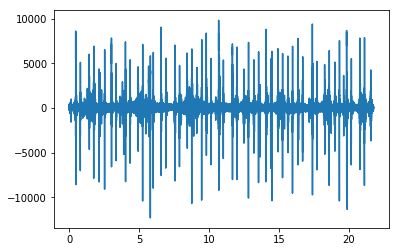

In [31]:
#apt-get install python-matplotlib
from pylab import *
plot(t, samples)

### Resuming ECG Physionet extracting data 

In [ ]:
#Exploring the data schema
record = wfdb.rdrecord('/media/tiagoooliveira/sda46/databases/physionet/training_2017/training/A00004', channels='all')
wfdb.plot_wfdb(record=record, title='Record A00004 from Physionet Challenge 2017') 

ARR_01
#display(record.__dict__)
#print(record.__dict__.__getitem__('fs'))

# Use the gqrs algorithm to detect qrs locations in the first channel
qrs_inds = processing.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)
print(qrs_inds.shape)
#[ print(sig) for sig in qrs_inds ]

#peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
        #title="GQRS peak detection on record 100")

print(record.__dict__.__getitem__('base_time')) #string

a = record.__dict__.__getitem__('file_name')[0]

print("Attribute: " +a)

#print(record.__dict__.__getitem__('byte_offset')) #int array
[ print(sig) for sig in record.__dict__.__getitem__('byte_offset') ]
#print(record.__dict__.__getitem__('comments')) #string array
[ print(sig) for sig in record.__dict__.__getitem__('comments') ]
#print(record.__dict__.__getitem__('file_name')) #string array
[ print(sig) for sig in record.__dict__.__getitem__('file_name') ]
#print(record.__dict__.__getitem__('fmt')) #string array - actual int
[ print(sig) for sig in record.__dict__.__getitem__('fmt') ]
print(record.__dict__.__getitem__('fs')) #int
print(record.__dict__.__getitem__('record_name')) #string
print(record.__dict__.__getitem__('sig_len')) #int
print(record.__dict__.__getitem__('n_sig')) #int
print(record.__dict__.__getitem__('init_value')) #int array
print('p_signal')
#print(record.__dict__.__getitem__('p_signal')) #double array
[ print(sig) for sig in record.__dict__.__getitem__('p_signal') ]
print('units')
#print(record.__dict__.__getitem__('units')) #string array
[ print(sig) for sig in record.__dict__.__getitem__('units') ]
print('sig_name')
#print(record.__dict__.__getitem__('sig_name')) #string array
[ print(sig) for sig in record.__dict__.__getitem__('sig_name') ]
print('samps_per_frame')
#print(record.__dict__.__getitem__('samps_per_frame')) #int array
[ print(sig) for sig in record.__dict__.__getitem__('samps_per_frame') ]

#####Also extract and persist per sample: Peak, QRS, RR 
#####explore other representative attributes from the ECG file

# Can also read the same files hosted on Physiobank https://physionet.org/physiobank/database/
# in the challenge/2015/training/ database subdirectory. Full url = https://physionet.org/physiobank/database/challenge/2015/training/
#record2 = wfdb.rdrecord('a103l', pb_dir = 'challenge/2015/training/')

#display(record.e_p_signal)
# Show that different channels have different lengths. Channel 1 has 2 samples/frame, hence has 2x as many samples.
#print([len(s) for s in record.p_signal])
print(record.p_signal.shape)
#print(record.base_date)


In [11]:
#Function responsible for return a list with all the wfdb ecg valid files for extracting/loading
def ecg_files(path):
    for (dirpath, dirnames, filenames) in walk(path):
        #sometimes the pair (.mat,.hea) is missing the most important file .hea
        return [ path + fi.replace(".mat","") for fi in filenames if not fi.endswith(".hea") ]
    

In [ ]:
path = "/media/tiagoooliveira/sda46/databases/physionet/training_2017/training/"

ecgList = ecg_files(path)

#A02618
#2256
#print(len(ecgList[3:]))
#print(ecgList[2255:])

In [ ]:
#Cypher script to create the chained timeseries for the 300Hz frequency so then the signal points will be zipped with
#Neo4jFrequencyModel_f300.cql file 

#WITH range(1, 20000) AS freq
#FOREACH(f in freq | CREATE (:Fs300 {id:f*0.003333333}))
        
#MATCH (fs:Fs300)
#WITH fs
#ORDER BY fs.id
#WITH collect(fs) as fss
#FOREACH(i in RANGE(0, length(fss)-2) | 
#    FOREACH(fs1 in [fss[i]] | 
#        FOREACH(fs2 in [fss[i+1]] | 
#            CREATE UNIQUE (fs1)-[:NEXT]->(fs2))))

In [21]:

#load all the refences in a collection, to prevent IO consumption
#These references are the labels for each sample of ecg exam

def transflabels(filename):
    ifile = open(filename, "rU")
    reader = csv.reader(ifile, delimiter=",")
    
    diag = {
        "N": "NormalSinusRhythm",
        "AF": "AtrialFibrillation",
        "O": "OtherRhythm",
        "~": "Noisy"
    }
    
    result = {}

    for row in reader:
        result[row[0]] = diag.get(row[1],"Undef")
    
    ifile.close()
    return result

#labels = transflabels(path + "REFERENCE-v3_revisited.csv")
#labels.get('A08412')

/home/tiagoooliveira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 'U' mode is deprecated
  """


In [ ]:
#Function responsible for processing each record.
#This function will gather the metadata regarding to ecg signal to create the timeseries on Neo4j
def ecg_insert_signal(tx, record):
    file_name = record.__dict__.__getitem__('file_name')[0]
    fs = record.__dict__.__getitem__('fs')
    record_name = record.__dict__.__getitem__('record_name')
    sig_len = record.__dict__.__getitem__('sig_len')
    n_sig = record.__dict__.__getitem__('n_sig')
    sig_name = record.__dict__.__getitem__('sig_name')[0]
    base_time = record.__dict__.__getitem__('base_time')
    label = labels.get(record_name,"Undef")#ecg_get_label(file_name)
    
    #create instance of header exame
    tx.run("CREATE (rec:Record {file_name:$file_name, fs:$fs, record_name:$record_name, sig_len:$sig_len, n_sig:$n_sig, base_time:$base_time}) ",
           file_name=file_name, fs=fs, record_name=record_name, sig_len=sig_len, n_sig=n_sig, base_time=base_time)

    #create instance of type jof signal    
    tx.run("MERGE (tp:Type {name:$type_name})",
           type_name=sig_name)
    
    #create instance of DiagnosticReport    
    tx.run("MERGE (diag:DiagnosticReport {name:$name})",
              name=labels.get(record_name,"OtherRhythm"))
    
    f = 0
    #insert signal values
    #zipping with timeseries
    for value in record.__dict__.__getitem__('p_signal'):
        #Insert signal 
        f += 1
        freq_value = f * 0.003333333
        tx.run("MATCH (rec:Record {file_name:$file_name, fs:$fs, record_name:$record_name, sig_len:$sig_len, n_sig:$n_sig, base_time:$base_time }), (tp:Type {name:$type_name}), (diag:DiagnosticReport {name:$diagnostic}), (fs:Fs300 {id:$id_freq_value}) "
            "CREATE (tp)<-[:OF_TYPE]-(sig:Signal{value:$value})-[:BELONGS_TO]->(rec)"
            "MERGE (sig)-[:HAPENED_ON]->(fs) "
            "MERGE (rec)-[:DIAGNOSE_OF]->(diag)",
               file_name=file_name, fs=fs, record_name=record_name, sig_len=sig_len, n_sig=n_sig, base_time=base_time, 
               diagnostic=label,type_name=sig_name,id_freq_value=freq_value,value=value[0])
    print(f)

In [24]:
#Test neo4j insert for one single record
#uri = "bolt://localhost:7687"
#driver = GraphDatabase.driver(uri, auth=("neo4j", "neo4jj4neo"))
#record = wfdb_p.rdrecord(pathfile, channels='all')
#def ecg_insert_ecg_item(tx, record):
#https://neo4j.com/docs/api/python-driver/current/
#https://neo4j.com/docs/developer-manual/current/drivers/sessions-transactions/

def loadECGtoNeo4j(lst):
    #Iterate over this block of code to load all the files
    for ecgfile in lst:
        record = wfdb.rdrecord(ecgfile, channels='all')
        #wfdb.plot_wfdb(record=record, title='Record a103l from Physionet Challenge 2017') 

        with driver.session() as session:
            ecg_insert_signal(session, record)
        
        print(ecgfile + " :: Done")

In [ ]:
loadECGtoNeo4j(ecgList)

In [ ]:
#TODO
#Insert other ECG attributes in order to try different feature selections to improve the accuracy on the train and test 
def ecg_insert_processed_properties(tx, record):
    #peak, qrs, RR
    # Use the gqrs algorithm to detect qrs locations in the first channel
    
    file_name = record.__dict__.__getitem__('file_name')[0]

    qrs_inds = processing.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)
    print(qrs_inds.shape)
    #[ print(sig) for sig in qrs_inds ]

    #peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
        #title="GQRS peak detection on record 100")

### Second Phase: designing the model

In [51]:
#Preprocessing
#normalization
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
x_train_norm = mms.fit_transform(x_train)

In [15]:
#USE CUDA
#visualize
#vectorize
#normalize
#visualize

In [ ]:
#https://arxiv.org/pdf/1605.05273.pdf
#Learning Convolutional Neural Networks for Graphs
#LSTM
#Hidden Markov Models
#RNN
#Graph Neuron Network
#structure detection
###########################################
#Start with Random Forest

In [34]:
import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources

In [35]:
#Random Forest Parameters
num_steps = 500 # Total steps to train
batch_size = 512 # The number of samples per batch
num_classes = 4 # The 10 digits
num_features = 18286 # Each image is 28x28 pixels
num_trees = 10
max_nodes = 1000

In [36]:
X = tf.placeholder(tf.float32, shape=[None, num_features])
# For random forest, labels must be integers (the class id)
Y = tf.placeholder(tf.int32, shape=[None])

In [37]:
hparams = tensor_forest.ForestHParams(num_classes=num_classes,
                                      num_features=num_features,
                                      num_trees=num_trees,
max_nodes=max_nodes).fill()

In [38]:
# Build the Random Forest
forest_graph = tensor_forest.RandomForestGraphs(hparams)
# Get training graph and loss
train_op = forest_graph.training_graph(X, Y)
loss_op = forest_graph.training_loss(X, Y)

INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'num_trees': 10, 'max_nodes': 1000, 'bagging_fraction': 1.0, 'feature_bagging_fraction': 1.0, 'num_splits_to_consider': 135, 'max_fertile_nodes': 0, 'split_after_samples': 250, 'valid_leaf_threshold': 1, 'dominate_method': 'bootstrap', 'dominate_fraction': 0.99, 'model_name': 'all_dense', 'split_finish_name': 'basic', 'split_pruning_name': 'none', 'collate_examples': False, 'checkpoint_stats': False, 'use_running_stats_method': False, 'initialize_average_splits': False, 'inference_tree_paths': False, 'param_file': None, 'split_name': 'less_or_equal', 'early_finish_check_every_samples': 0, 'prune_every_samples': 0, 'num_classes': 4, 'num_features': 18286, 'bagged_num_features': 18286, 'bagged_features': None, 'regression': False, 'num_outputs': 1, 'num_output_columns': 5, 'base_random_seed': 0, 'leaf_model_type': 0, 'stats_model_type': 0, 'finish_type': 0, 'pruning_type': 0, 'split_type': 0}


In [39]:
# Measure the accuracy
infer_op, _, _ = forest_graph.inference_graph(X)
correct_prediction = tf.equal(tf.argmax(infer_op, 1), tf.cast(Y, tf.int64))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [40]:
# Initialize the variables (i.e. assign their default value) and forest resources
init_vars = tf.group(tf.global_variables_initializer(),
    resources.initialize_resources(resources.shared_resources()))

# Start TensorFlow session
sess = tf.Session()

# Run the initializer
sess.run(init_vars)

In [42]:
forest_clf = RandomForestClassifier(random_state=42)

In [46]:
data = sgl.load_watch()

In [55]:
data["X"][1].size

14748

In [20]:
#Set the lenght for all the ecg signal array in 50000
total_series_length = 50000
echo_step = 3
batch_size = 5
x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
y = np.roll(x, echo_step)

In [23]:
print(x.shape)
print(y.shape)


(50000,)
(50000,)


In [25]:
x = x.reshape((batch_size, -1))
y = y.reshape((batch_size, -1))

In [27]:
print(x.shape)
print(y.shape)

(5, 10000)
(5, 10000)


In [19]:
y[0:]

array([0, 0, 1, ..., 0, 0, 1])

In [3]:
hello = tf.constant("Hello, TensorFlow!")
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


In [5]:
print(sess.run(tf.constant(123)*tf.constant(456)))

56088


In [20]:
#Testing GPU availability on my machine
# Creates a graph.
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run)

<bound method BaseSession.run of <tensorflow.python.client.session.Session object at 0x7f52dc406438>>


In [25]:
from tensorflow.python.client import device_lib

def get_available_gpus(tp):
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == tp]

get_available_gpus("GPU")

[]

In [27]:
tf.test.is_gpu_available()
tf.test.gpu_device_name()

# Creates a graph.
c = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
tf.reset_default_graph()

#for d in ['/gpu:1']:
#    with tf.device(d):
#        a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])
#        b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
#        c.append(tf.matmul(a, b))

with tf.device('/cpu:0'):
    sum = tf.add_n(c)

    # Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(sum))

''

In [7]:
#Return all the ECG persisted on Neo4j
def listall_ECG():
    c = []
    with driver.session() as session:
        with session.begin_transaction() as tx:
            result = tx.run("MATCH (r:Record) RETURN r.file_name")
            for record in result:
                exam = record["r.file_name"]
                c.append(exam)
                #print(record["r.file_name"])
                
    return c

In [8]:
#Rightpadding the ECG signal lenght in a standard value
def signal_rightpad(collec, stdlen):
    shape = (1, stdlen) #setting the size
    sigma = np.array(collec)
    sigma.resize(shape) #Resize the matrix and fill with zeros
    return sigma

#print(signal_rightpad([11, 18, 10, 14,  7,  1, 2,  3, 9,  6,  5], 100))

In [9]:
#Function responsible for return X and Y (train or test dataset) collected from neo4j. Shaped as matrix
def ecgdataset_to_collection(listToFill):
    #pbarcounter = len(listToFill)
    #bar = pyprind.ProgBar(pbarcounter, bar_char='█')

    starttotal = time.time()
    Y = []
    X = []
    maxlen = 9000 #Cypher:: MATCH (n:Record) RETURN MAX(n.sig_len) --18286
    diag = {
        "NormalSinusRhythm" : 0,
        "AtrialFibrillation" : 1,
        "OtherRhythm" : 2,
        "Noisy" : 3,
        "Undef" : 4}
    #normalize

    #Map the Y as continuous values
    with driver.session() as session:
        with session.begin_transaction() as tx:
            for item in listToFill:
                start = time.time()
                x = []
                y = 0
                insert_at = 0
                cypher = "MATCH (s:Signal)-[:BELONGS_TO]->(r:Record {file_name:'" + item + "'})-[:DIAGNOSE_OF]->(d:DiagnosticReport) RETURN s.value, d.name, r.sig_len"
                #print(cypher)
                result = tx.run(cypher)
                for record in result:
                    #the shape of the points vector could change in case it is demanded by the algorithm used for prediction
                    x[insert_at:insert_at] = [float(record["s.value"])]
                    y = diag.get(record["d.name"], 4)
                    insert_at+=1
                    x_size = len(x)
                    if insert_at == maxlen:
                        break
                    
                X.append(signal_rightpad(x,maxlen)) #right padding for adjusting the shape
                Y.append(y)
                end = time.time()
                #bar.update()
                print("Item: %s Original Size: %d Final Size: %d | %d of %d | Time:%f" % ( item, x_size, maxlen, len(Y), len(listToFill), end - start))
    endtotal = time.time()
    print("Time total:%f" % ( endtotal - starttotal))
    return np.squeeze(X, axis=0), Y #squeeze for removing one dimension 

In [10]:
#Function responsible for return a total of specific [num] of random samples and labels
def next_batch(num, data, labels):
    
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [ ]:
#listall_ECG
#shuffle list
#Normalize?
#split train/test
#ecgdataset_to_collection
#send to model
    
#List of exams - example
#a = ['A08350.mat', 'A08042.mat', 'A08023.mat', 'A06927.mat', 'A02531.mat', 'A03728.mat', 'A05909.mat', 'A05673.mat', 'A01020.mat', 'A06881.mat', 'A01931.mat', 'A06979.mat', 'A04833.mat', 'A04124.mat', 'A02875.mat', 'A04866.mat', 'A06852.mat', 'A03816.mat', 'A04705.mat', 'A03422.mat', 'A04340.mat', 'A08383.mat', 'A01367.mat', 'A04538.mat', 'A02762.mat', 'A03479.mat', 'A00003.mat', 'A01630.mat', 'A03618.mat', 'A03375.mat']
exams = listall_ECG()

#shuffling exams
np.random.shuffle(exams)

X, Y = ecgdataset_to_collection(exams)

#splitting train vs test
data_train, data_test, labels_train, labels_test = train_test_split(X, Y, test_size=0.20, random_state=42)


#splitting - traing - validation
#data_train, data_test, labels_train, labels_test = train_test_split(X, Y, test_size=0.30, random_state=42)
#x_test, x_val, y_test, y_val = train_test_split(data_test, labels_test, test_size=0.5)

In [12]:
#training - RandomForest
#model params setup

# Parameters
num_steps = 1500 # Total steps to train
batch_size = 1024 # The number of samples per batch
num_classes = 5 # anomalies
num_features = 9000 # Each exam padded with the maximum length (18286)
num_trees = 20
max_nodes = 2048

tf.reset_default_graph()

#Features
X_ = tf.placeholder(tf.float32, shape=[None, num_features])

#Labels - Randomforest-Integers
Y_ = tf.placeholder(tf.int32, shape=[None])

# Random Forest Parameters
hparams = tensor_forest.ForestHParams(num_classes=num_classes,
                                      num_features=num_features,
                                      num_trees=num_trees,
                                      max_nodes=max_nodes).fill()

# Build the Random Forest
forest_graph = tensor_forest.RandomForestGraphs(hparams)

# Get training graph and loss
train_op = forest_graph.training_graph(X_, Y_)
loss_op = forest_graph.training_loss(X_, Y_)

#Measure the accuracy
infer_op, _, _ = forest_graph.inference_graph(X_)
correct_prediction = tf.equal(tf.argmax(infer_op, 1), tf.cast(Y_, tf.int64))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize the variables
init_vars = tf.group(tf.global_variables_initializer(),
    resources.initialize_resources(resources.shared_resources()))

# Start TensorFlow session
sess = tf.Session()

# Run the initializer
sess.run(init_vars)

## Training
for i in range(1, num_steps + 1):
    batch_x, batch_y = next_batch(batch_size, data_train, labels_train)
    _, l = sess.run([train_op, loss_op], feed_dict={X_: batch_x, Y_: batch_y})
    if i % 50 == 0 or i == 1:
        acc = sess.run(accuracy_op, feed_dict={X_: batch_x, Y_: batch_y})
        print('Step %i, Loss: %f, Acc: %f' % (i, l, acc))

INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'num_trees': 20, 'max_nodes': 2048, 'bagging_fraction': 1.0, 'feature_bagging_fraction': 1.0, 'num_splits_to_consider': 94, 'max_fertile_nodes': 0, 'split_after_samples': 250, 'valid_leaf_threshold': 1, 'dominate_method': 'bootstrap', 'dominate_fraction': 0.99, 'model_name': 'all_dense', 'split_finish_name': 'basic', 'split_pruning_name': 'none', 'collate_examples': False, 'checkpoint_stats': False, 'use_running_stats_method': False, 'initialize_average_splits': False, 'inference_tree_paths': False, 'param_file': None, 'split_name': 'less_or_equal', 'early_finish_check_every_samples': 0, 'prune_every_samples': 0, 'num_classes': 5, 'num_features': 9000, 'bagged_num_features': 9000, 'bagged_features': None, 'regression': False, 'num_outputs': 1, 'num_output_columns': 6, 'base_random_seed': 0, 'leaf_model_type': 0, 'stats_model_type': 0, 'finish_type': 0, 'pruning_type': 0, 'split_type': 0}
Step 1, Loss: -1.000000, Acc: 0

In [13]:
#Test RandomForest Model

print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X_: data_test, Y_: labels_test}))

Test Accuracy: 0.58245385


In [16]:
from sklearn.preprocessing import Normalizer

In [17]:
#Normalize features
Normalizer().fit_transform(X)

array([[-0.00285915, -0.00356414, -0.00430831, ..., -0.00203665,
        -0.00332915, -0.00399498],
       [ 0.00123735,  0.00123735,  0.00123735, ..., -0.00129627,
        -0.00111951, -0.00094274],
       [ 0.00065596,  0.0092655 ,  0.01951494, ...,  0.00114794,
         0.00122993,  0.00139392],
       ...,
       [-0.00170161, -0.00184341, -0.00198522, ..., -0.00283602,
        -0.00198522, -0.00113441],
       [-0.01998701, -0.02119529, -0.02044011, ..., -0.00755177,
        -0.00755177, -0.00750142],
       [ 0.00213077,  0.00286322,  0.00412836, ...,  0.01584757,
         0.01544805,  0.0151817 ]])

In [18]:
X

array([[-0.073, -0.091, -0.11 , ..., -0.052, -0.085, -0.102],
       [ 0.021,  0.021,  0.021, ..., -0.022, -0.019, -0.016],
       [ 0.008,  0.113,  0.238, ...,  0.014,  0.015,  0.017],
       ...,
       [-0.024, -0.026, -0.028, ..., -0.04 , -0.028, -0.016],
       [-0.397, -0.421, -0.406, ..., -0.15 , -0.15 , -0.149],
       [ 0.032,  0.043,  0.062, ...,  0.238,  0.232,  0.228]])

In [ ]:
np.random.seed(7)

#If the weights in a network start too small, then the signal shrinks as it passes through each layer until it’s 
#too tiny to be useful.
#If the weights in a network start too large, then the signal grows as it passes through each layer until it’s 
#too massive to be useful.   
#tf.keras.initializers.glorot_uniform(seed=42)

#Create MLP model
model = Sequential()
model.add(Dense(4, input_dim=9000, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='relu'))


#testing optimizers. Wich one perform the best (SGD, Adagrad)
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adagrad = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)

#binary_crossentropy -> Loss 16
#mean_squared_error -> 2.8
model.compile(loss='mean_squared_error', optimizer=adagrad, metrics=['accuracy'])

#Keras MLP for train, test and validation
model.fit(np.array(X), np.array(Y), validation_split=0.33, epochs=150, batch_size=500)

## Final thoughts
Unfortunately on last December/2018 my Linux Ubuntu crashed and part of my file system got corrupted. 
When I tried to load the Physionet 2017 challenge again to reproduce all the steps, many error appear on Loading phase regarding to WFDB files (.hea, .mat) corrupted.

For now, I would like to perform more exploratorial graph algorithms and feature engineering over the signal data on Neo4j and also load additional features like QRS, Peaks other signal leads/channels and observe the impact on the precision/accuracy/Recall for both models (RandomForest and MLP) reaching around 60% on test accuracy.

At that time I took a picture (1010575.jpg) with the results for the MLP model. It was interesting to see such convergence between both the test accuracy (RandomForest and MLP).


### For the next steps, 
I'll resume the exploratorial stuff, adding different datasets and features from different shapes and formats like audio and another very predictive diseases datasets like Apnea, Blood Coagulation, Electroencephalography with associated dysfunction or disease and so on.

I'll take the opportunity to leverage some Grahp Algorithms (pathfinding, similarity, community detection) in order to improve the Feature Engineering phase. Once this database tends to be huge, PySpark seems to be the fittest option for all the data engineering processing, as I could see on previous explorations.

On the ML models perspective, I intend to test some temporal model (like LSTM/RNN) in order to predict disease on the signal capturing time, for example.

On the application architectural perspective, I'm getting progress on the ingestion pipeline and persistence modules using an Actor Model with Akka approach with Kafka Streams  to be very scalable and flexible to add different processing modules in the pipeline. As soon as possible I'll be able to perform predictictions in near-realtime by putting the ML Test Model on a step in the Processing Pipeline (Tensorflow/Scala or DL4j for a good JVM fit).

I just defined a json (ecgIngestionChunk.json) expected from external clients assuming such idempotency on the processing/perstency layer.